In [6]:


import bs4 as bs
import urllib.request
import pandas as pd




def extract_player_data(table_rows_variable):
    """
    Extract and return the desired information from the td elements within the table rows.
    :param table_rows_variable:
    :return:
    """
    # Create the emply list to store the player data
    player_data = []
    for row in table_rows_variable: #for each row, do the following:
        # Get the text for each table data (td) element in the row
        # Some player names end with
        player_list = [td.get_text()[:-2] if td.get_text().endswith("*+") else td.get_text()[:-1] if td.get_text().endswith("+") or td.get_text().endswith("*") else td.get_text() for td in row.find_all("td")]
        # there are some empty table rows, which are the repeated
        # column headers in the table
        # we skip over those rows and and continue the for loop
        if not player_list:
            continue
            # Extracting the player links
            # Instead of a list we create a dictionary, this way we can easily
            # match the player name with their pfr url
            # For all "a" elements in the row, get the text
            # NOTE: Same " HOF" text issue as the player_list above
        links_dict = {(link.get_text()): link["href"] for link in row.find_all("a", href=True)}
        player_list.insert(0, '') #TODO figure out why this is even necessary. I have an "Rk" table header, but no data for it.
        player_list.append(links_dict.get(player_list[1], ""))
        player_list.append(links_dict.get(player_list[2], ""))
        player_data.append(player_list)
    return player_data

#data = extract_player_data(table_rows)

#df_2017 = pd.DataFrame(data, columns=column_headers)

season_dfs_list = []

errors_list = []

url_template = "https://www.pro-football-reference.com/years/{year}/fantasy.htm"
# for each year from 2000 to (and including) 2017
for year in range(2000, 2018):
    # Using try/except block to catch and inspect any urls that cause an error
    try:
        # get the season URL
        url = url_template.format(year=year)

        # get the html
        html = urllib.request.urlopen(url)

        # create the beautiful soup object
        soup = bs.BeautifulSoup(html, 'lxml')

        # get column headers
        column_headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        column_headers[1] = 'Player'
        column_headers[2] = 'Team'
        column_headers[3] = 'Position'
        column_headers[7] = 'Pass_Cmp'
        column_headers[8] = 'Pass_Att'
        column_headers[9] = 'Pass_Yds'
        column_headers[10] = 'Pass_TD'
        column_headers[11] = 'Pass_INT'
        column_headers[12] = 'Rush_Att'
        column_headers[13] = 'Rush_Yds'
        column_headers[14] = 'Rush_YpA'
        column_headers[15] = 'Rush_TD'
        column_headers[16] = 'Rec_Tgt'
        column_headers[18] = 'Rec_Yds'
        column_headers[19] = 'Rec_YpR'
        column_headers[20] = 'Rec_TD'
        column_headers[21] = 'Two_PT_Made'
        column_headers[22] = 'Two_PT_Pass'
        column_headers[23] = 'Fantasy_Pts'
        column_headers[24] = 'PPR_Pts'
        column_headers[25] = 'DraftKings_Pts'
        column_headers[26] = 'FanDuel_Pts'
        column_headers.extend(["player_nfl_link", "player_team_link"])
        

        # select the data from the tale using the '#fantasy tr' CSS selector
        table_rows = soup.select("#fantasy tr")[1:]

        # extract player data from the table rows
        player_data = extract_player_data(table_rows)

        # create the dataframe for the current fantasy season
        year_df = pd.DataFrame(player_data, columns=column_headers)

        # add the year of the season to the dataframe
        year_df.insert(0,"Season", year)

        # append the current dataframe to the list of dataframes
        season_dfs_list.append(year_df)

    except Exception as e:
        # store the url and the error it causes in a list
        error =[url, e]
        # then append it to the list of errors
        errors_list.append(error)

fantasy_df = pd.concat(season_dfs_list, ignore_index=True)

print(column_headers)
print(fantasy_df.head())



['Rk', 'Player', 'Team', 'Position', 'Age', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Pass_INT', 'Rush_Att', 'Rush_Yds', 'Rush_YpA', 'Rush_TD', 'Rec_Tgt', 'Rec', 'Rec_Yds', 'Rec_YpR', 'Rec_TD', 'Two_PT_Made', 'Two_PT_Pass', 'Fantasy_Pts', 'PPR_Pts', 'DraftKings_Pts', 'FanDuel_Pts', 'VBD', 'PosRank', 'OvRank', 'player_nfl_link', 'player_team_link']
   Season Rk            Player Team Position Age   G  GS Pass_Cmp Pass_Att  \
0    2000       Marshall Faulk  STL       RB  27  14  14        0        0   
1    2000       Edgerrin James  IND       RB  22  16  16        0        0   
2    2000     Daunte Culpepper  MIN       QB  23  16  16      297      474   
3    2000          Jeff Garcia  SFO       QB  30  16  16      355      561   
4    2000         Eddie George  TEN       RB  27  16  16        0        0   

          ...          Two_PT_Pass Fantasy_Pts PPR_Pts DraftKings_Pts  \
0         ...                              381     460          465.9   
1         ...     

In [8]:
player_ids = fantasy_df.player_nfl_link.str.extract("/.*/.*/(.*)\.", expand=False)

fantasy_df["Player_ID"] = player_ids

pfr_url = "https://www.pro-football-reference.com/"
fantasy_df.player_nfl_link = pfr_url + fantasy_df.Player_ID

player_id_df = fantasy_df.loc[:, ["Player", "Player_ID", "player_nfl_link"]]

In [9]:
fantasy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10650 entries, 0 to 10649
Data columns (total 34 columns):
Season              10650 non-null int64
Rk                  10650 non-null object
Player              10650 non-null object
Team                10650 non-null object
Position            10650 non-null object
Age                 10650 non-null object
G                   10650 non-null object
GS                  10650 non-null object
Pass_Cmp            10650 non-null object
Pass_Att            10650 non-null object
Pass_Yds            10650 non-null object
Pass_TD             10650 non-null object
Pass_INT            10650 non-null object
Rush_Att            10650 non-null object
Rush_Yds            10650 non-null object
Rush_YpA            10650 non-null object
Rush_TD             10650 non-null object
Rec_Tgt             10650 non-null object
Rec                 10650 non-null object
Rec_Yds             10650 non-null object
Rec_YpR             10650 non-null object
Rec_TD    

In [10]:
fantasy_df = fantasy_df.apply(pd.to_numeric, errors="ignore")

In [11]:
fantasy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10650 entries, 0 to 10649
Data columns (total 34 columns):
Season              10650 non-null int64
Rk                  0 non-null float64
Player              10650 non-null object
Team                10650 non-null object
Position            10650 non-null object
Age                 10649 non-null float64
G                   10552 non-null float64
GS                  10409 non-null float64
Pass_Cmp            10649 non-null float64
Pass_Att            10649 non-null float64
Pass_Yds            10649 non-null float64
Pass_TD             10649 non-null float64
Pass_INT            10649 non-null float64
Rush_Att            10649 non-null float64
Rush_Yds            10649 non-null float64
Rush_YpA            5431 non-null float64
Rush_TD             10649 non-null float64
Rec_Tgt             10005 non-null float64
Rec                 10649 non-null float64
Rec_Yds             10649 non-null float64
Rec_YpR             7772 non-null float64

In [12]:
num_cols = fantasy_df.columns[fantasy_df.dtypes != object]

fantasy_df.loc[:, num_cols] = fantasy_df.loc[:, num_cols].fillna(0)

In [13]:
fantasy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10650 entries, 0 to 10649
Data columns (total 34 columns):
Season              10650 non-null int64
Rk                  10650 non-null float64
Player              10650 non-null object
Team                10650 non-null object
Position            10650 non-null object
Age                 10650 non-null float64
G                   10650 non-null float64
GS                  10650 non-null float64
Pass_Cmp            10650 non-null float64
Pass_Att            10650 non-null float64
Pass_Yds            10650 non-null float64
Pass_TD             10650 non-null float64
Pass_INT            10650 non-null float64
Rush_Att            10650 non-null float64
Rush_Yds            10650 non-null float64
Rush_YpA            10650 non-null float64
Rush_TD             10650 non-null float64
Rec_Tgt             10650 non-null float64
Rec                 10650 non-null float64
Rec_Yds             10650 non-null float64
Rec_YpR             10650 non-null f

In [20]:
# Import necessary packages, set some plotting styles
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

# set the font scaling and the plot sizes
sns.set(font_scale=1.65)
rcParams["figure.figsize"] = 12, 9

/Users/coltkess/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


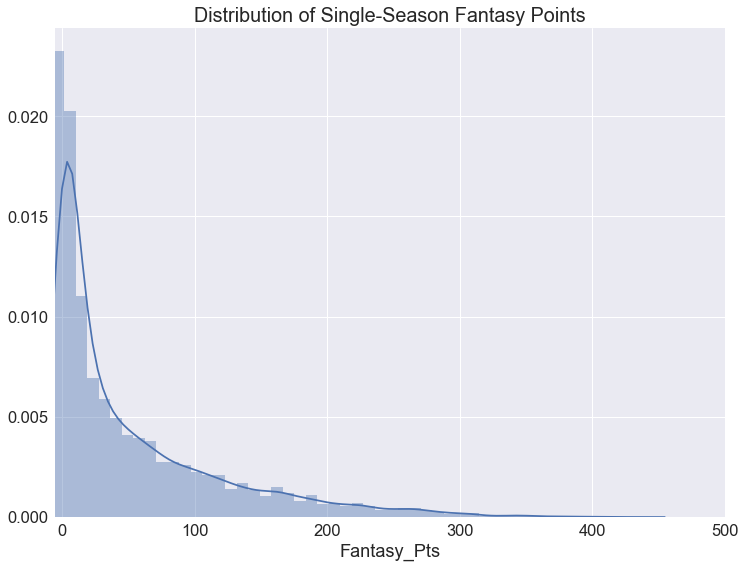

In [21]:
# Use distplot to view distribution
sns.distplot(fantasy_df.Fantasy_Pts)
plt.title("Distribution of Single-Season Fantasy Points")
plt.xlim(-5, 500)
plt.show()

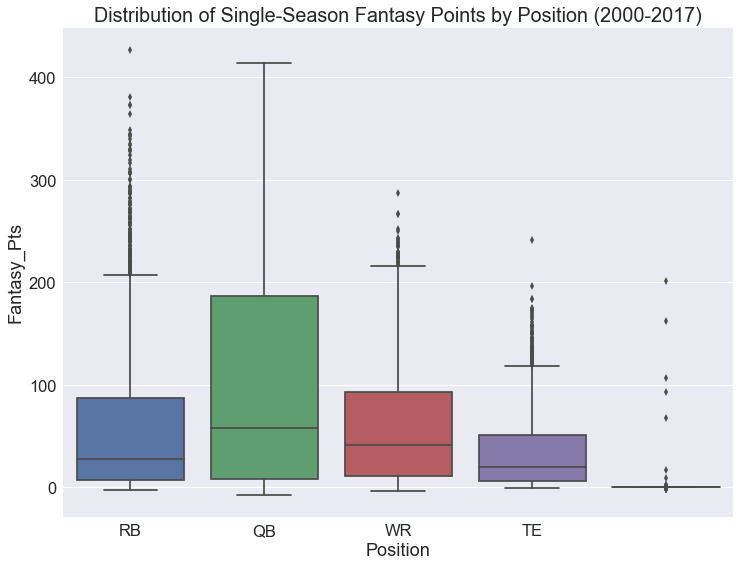

In [23]:
sns.boxplot(x="Position", y="Fantasy_Pts", data=fantasy_df)
plt.title("Distribution of Single-Season Fantasy Points by Position (2000-2017)")
plt.show()
